In [1]:
#Librerias para ML

import os

#Manejo de la base de datos
import pandas as pd
import numpy as np

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
#from bayes_opt import BayesianOptimization
#from hyperopt import hp

#Creación de modelo
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
#from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from skelm import ELMRegressor
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

import statsmodels.api as sm

#Para graficas
import matplotlib.pyplot as plt
import seaborn as sns

#Private functions
from own_functions import residuos
from own_functions import comparisson
from own_functions import scorer

#Guardando los modelos
import pickle

Using TensorFlow backend


# 1. Cargando las BD

In [2]:
#Se crea un dataframe con los datos tratados
df_estandar = pd.read_csv('Train_prep_iter6.csv')

## 1.1 División de la base de datos en datos de entrada y salida

In [4]:
# Separamos de nuestros datos la variable de salida
output_name = ['load_shortfall_3h']

In [5]:
snow_3h = [x for x in df_estandar.columns if 'snow_3h' in x]
rain_3h = [x for x in df_estandar.columns if 'rain_3h' in x]
print(snow_3h,rain_3h)

['Bilbao_snow_3h', 'Valencia_snow_3h'] ['Seville_rain_3h', 'Barcelona_rain_3h']


In [6]:
clouds  = [x for x in df_estandar.columns if 'clouds_all' in x]
clouds.pop(0)
print(clouds)

['Seville_clouds_all', 'Madrid_clouds_all']


In [7]:
to_drop_1 = []
to_drop_1.extend(snow_3h)
to_drop_1.extend(rain_3h)

In [8]:
# Separación de las variables

#BD Estandarizada
x_est = df_estandar.drop(columns=to_drop_1).drop(columns = output_name)
y_est = df_estandar[output_name]

In [10]:
columns_x1=[x for x in x_est.columns if 'Estación' not in x and 'weather_id' not in x]
columns_x2=[x for x in x_est.columns if 'Estación' in x or 'weather_id' in x]
x_est1=x_est[columns_x1]
x_est2=x_est[columns_x2]
scaler_x = StandardScaler()
#nombres = x_est.columns
x_est1 = scaler_x.fit_transform(x_est1)
x_est1 = pd.DataFrame(x_est1, columns = columns_x1)
x_est=pd.concat([x_est2,x_est1],axis=1)

scaler_y = StandardScaler()
nombres = y_est.columns
y_est = scaler_y.fit_transform(y_est)
y_est = pd.DataFrame(y_est, columns = nombres)

# 2. Datos de entrenamiento y prueba 

In [13]:
# División de los datos en train y test
#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

#Para los datos estandarizados
X_train_est, X_test_est, y_train_est, y_test_est = train_test_split(
                                        x_est,
                                        y_est.values.reshape(-1,1),
                                        train_size   = 0.9,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [14]:
# # División de los datos en train y test
# #En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

# #Para los datos con min max
# X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(
#                                         x_minmax,
#                                         y_minmax.values.reshape(-1,1),
#                                         train_size   = 0.8,
#                                         random_state = 1234,
#                                         shuffle      = True
#                                     )

# 3. Creación de los modelos

## 3.5 Deep Neural Network

In [15]:
#Definimos función objetivo para el KerasTuner
def build_model(hp):
    ### Espacio a evaluar ###
    dnn_layers_ss = [1,2,3,4,5]
    dnn_units_min, dnn_units_max = 32, 512
    #dnn_units=[100, 200, 300, 400, 500]
    #dropout_ss = [0.3, 0.5]
    d_out_min, d_out_max = 0.1, 0.5
    active_func = 'mish'
    lr_min, lr_max = 1e-4, 1e-1
    #lr_ss= [0.1,0.0001]
    #########################
    
    #Seleccionando la taza de aprendizaje
    lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    #lr=hp.Choice("learning_rate", lr_ss)
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr)

    #Seleccionando valor de dropout para cada capa oculta
    dropout = hp.Float('drop_out', min_value=d_out_min, max_value=d_out_max)
    #dropout=hp.Choice("drop_out", dropout_ss)

    #Seleccionando numero de capas ocultas
    #n_layers=hp.Choice("n_hidden layers", dnn_layers_ss)

    #Instanciando el modelo
    model = keras.Sequential()

    # Capa de entrada con 'X_train.shape[1]' características
    model.add(layers.Input(shape=(X_train_est.shape[1],)))  
    
    # Creando las capas ocultas

    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss)):
        neurons_layer_i= hp.Int(f"layer{layer_i+1}_units", min_value=dnn_units_min, max_value=dnn_units_max)
        #neurons_layer_i=hp.Choice("n_neurons", dnn_units)   #Seleccionando numero de neuronas para la capa oculta i
        model.add(layers.Dense(neurons_layer_i, activation=active_func, name=f"layer{layer_i+1}",kernel_regularizer=l2(1e-6))) #Añadimos capa oculta i
        model.add(layers.Dropout(dropout)) #Dropout a la capa oculta i

    model.add(layers.Dense(1, activation="linear",name="Output_layer"))  # Capa de salida con una neurona

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.MeanAbsoluteError(),  
              metrics=['mean_absolute_error']) 

    # # Patient early stopping
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50,min_delta=0.001)

    # # Entrenar el modelo
    # model.fit(np.array(X_train), y_train.ravel(), epochs=2000, verbose=0,validation_data=(np.array(X_test), y_test.ravel()), callbacks=[es])  # 2000 épocas de entrenamiento

    return model


In [16]:
#Get current path
folder = os.getcwd()

In [17]:
path = folder + '\\' + 'v2'

# 4. Hypertunnig

In [18]:
# Sintonización del modelo de la Red Neuronal Profunda
n_epochs=100
n_trials=500
obj = kt.Objective('val_loss', direction='min')
tuner = kt.BayesianOptimization(build_model, objective=obj, max_trials=n_trials, executions_per_trial=1,directory=path,project_name='p',overwrite=False)
tuner.search(np.array(X_train_est), y_train_est.ravel(), epochs=n_epochs, validation_data=(np.array(X_test_est), y_test_est.ravel()))

Reloading Tuner from c:\Users\Usuario\Desktop\UdeA\Monografia\00 Modelos finales\7A\v2\p\tuner0.json


In [19]:
best_model = build_model(tuner.get_best_hyperparameters(1)[0])
print(tuner.get_best_hyperparameters(1)[0])

# Patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=50,min_delta=0.001)

best_model.fit(np.array(X_train_est), y_train_est.ravel(), epochs=1000, verbose=0, callbacks=[es])



In [21]:
with open('ML_models'+'\\'+ 'ANN_tuned' + '.pkl', 'wb') as file:
        pickle.dump(best_model, file)

In [22]:
print(tuner.get_best_hyperparameters(1)[0].get('learning_rate'))
print(tuner.get_best_hyperparameters(1)[0].get('drop_out'))
print(tuner.get_best_hyperparameters(1)[0].get('n_layers'))
print(tuner.get_best_hyperparameters(1)[0].get('layer1_units'))
print(tuner.get_best_hyperparameters(1)[0].get('layer2_units'))
print(tuner.get_best_hyperparameters(1)[0].get('layer3_units'))
print(tuner.get_best_hyperparameters(1)[0].get('layer4_units'))

0.00048318247974559923
0.1
4
481
512
512
376


# 5. Evaluación

## 5.1 Metricas

In [23]:
results = {}

### 5.1.1 Random Forest

In [24]:
# Error de test del modelo de la Red Neuronal Profunda
y_test_DNN                      = best_model.predict(X_test_est)
results['Deep Neural Network']  = scorer(scaler_y.inverse_transform(y_test_est),scaler_y.inverse_transform(y_test_DNN.reshape(-1, 1)),'Deep Neural Network')

27/27 [==============================] - 0s 5ms/step


### 5.1.1 Resumen de resultados

In [34]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
df_results

,model,MAE,MAPE,MSE,MedAE,R2,RMSE
0,Deep Neural Network,2788.20548,0.858093,1.380133e+07,2164.723633,0.445557,3715.013651


## 5.2 Graficas

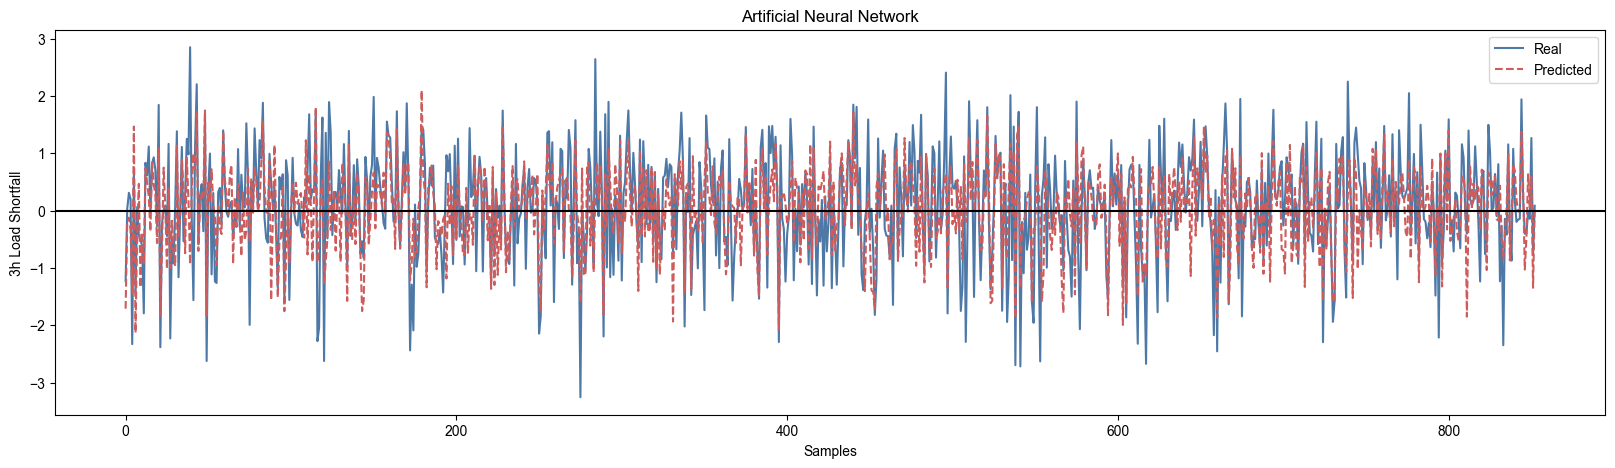

In [26]:
comparisson(y_test_est, y_test_DNN,'Artificial Neural Network')